### Importing required libraries for Twitter Text Analysis

In [103]:
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import regexp_tokenize

import string
from nltk.tokenize import word_tokenize
import re
import emoji
from nltk.corpus import stopwords
stop = set(stopwords.words("english"))

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import random

import spacy
nlp = spacy.load("en_core_web_sm")

from nltk.corpus import wordnet as wn
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Meteora\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Reading Raw Text File downloaded from Twitter API

Date Range:  August 2020 to August 2022

In [104]:
df = pd.read_csv(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\Twitter_topic_modelling_group_project.csv')

In [105]:
df.head(2)

,id,text,created_at,author_id,in_reply_to_user_id,lang,author,entities,referenced_tweets,media,geo
0,1570924626888527872,Dear Flipkart\n your customer care service is ...,2022-09-16T23:56:32.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1570921531097874432,@Flipkart I always try to buy any items from f...,2022-09-16T23:44:13.000Z,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [106]:
df.columns.to_list()

['id',
 'text',
 'created_at',
 'author_id',
 'in_reply_to_user_id',
 'lang',
 'author',
 'entities',
 'referenced_tweets',
 'media',
 'geo']

Dropping columns that are not needed 

In [107]:
df.drop(['id',
 'author_id',
 'in_reply_to_user_id',
 'lang',
 'author',
 'entities',
 'referenced_tweets',
 'media',
 'geo'], axis=1, inplace=True)

In [108]:
df.head(5)

,text,created_at
0,Dear Flipkart\n your customer care service is ...,2022-09-16T23:56:32.000Z
1,@Flipkart I always try to buy any items from f...,2022-09-16T23:44:13.000Z
2,@HlNOMARUSUMO @eurogamer Because that wasn’t a...,2022-09-16T23:41:27.000Z
3,@JD4293 @Flipkart Chor hai flipkart.try Amazon...,2022-09-16T23:23:44.000Z
4,@flipkartsupport @Flipkart i have been given ...,2022-09-16T23:22:49.000Z


Extracting day, hour and year from the datetime feature 

In [109]:
df['datetime_val'] = pd.to_datetime(df['created_at'])
df['day']=df['datetime_val'].dt.day
df['hour']=df['datetime_val'].dt.hour
df['year']=df['datetime_val'].dt.year

Extracting dataframe for the context year 2020 and 2021

In [110]:
df_context1 = df[(df['year'] >= 2020) & (df['year'] <=2021 )]

In [111]:
df_context1.shape

(574480, 6)

Picking out sample from the dataset . Shape of our data reduces to 10% of its original. 

In [112]:
df_context1 = df_context1.sample(frac=0.1)
df_context1.shape

(57448, 6)

In [113]:
df_context1=df_context1.reset_index(drop=True)

Preprocessing method includes regular expression tokenization, punctuation removal, words with character length less than 2 removal ad basic lemmatization.

In [114]:
def preprocessing(text):
    #words = word_tokenize(text)
    words = regexp_tokenize(text, pattern='\w+|\$[\d\.]+|\S+')
    tokens = [w for w in words if w.lower() not in string.punctuation]
    stopw = stopwords.words('english')
    tokens = [token for token in tokens if token not in stopw]
    # remove words less than three letters
    tokens = [word for word in tokens if len(word)>=3]
    # lemmatize
    lemma = WordNetLemmatizer()
    tokens = [lemma.lemmatize(word) for word in tokens] 
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text 

In [115]:
df_context1['clean_text']=df_context1['text'].apply(preprocessing)

In [116]:
df_context1.head()

,text,created_at,datetime_val,day,hour,year,clean_text
0,@Saurabh_L_Joshi Request you to share an alter...,2021-04-29T07:55:49.000Z,2021-04-29 07:55:49+00:00,29,7,2021,@Saurabh_L_Joshi Request share alternate conta...
1,the @Flipkart help bot AI is so outdated that ...,2021-10-07T17:09:29.000Z,2021-10-07 17:09:29+00:00,7,17,2021,@Flipkart help bot outdated say thing inspite ...
2,@Flipkart @flipkartsupport its been 4 days of ...,2021-09-19T07:47:36.000Z,2021-09-19 07:47:36+00:00,19,7,2021,@Flipkart @flipkartsupport day placing order i...
3,@rajneeeshkumar @sudarsansand @Naveen_Odisha @...,2021-10-03T11:11:41.000Z,2021-10-03 11:11:41+00:00,3,11,2021,@rajneeeshkumar @sudarsansand @Naveen_Odisha @...
4,"@HitachiHomes Hi Hitach team,\nYour team very...",2021-06-23T07:45:42.000Z,2021-06-23 07:45:42+00:00,23,7,2021,@HitachiHomes Hitach team Your team poor also ...


In [117]:
df_context1['clean_text']=df_context1['clean_text'].map(lambda x:re.sub('#|@[\w]+','',x))

Further preprocessing with special characters removal

In [118]:
df_context1.text[0]

'@Saurabh_L_Joshi Request you to share an alternate contact number which is not linked with Flipkart account. Appreciate your understanding. Going forward, please ensure that you do not share your order ID, email ID, contact details or any other (2/3)'

In [119]:
df_context1.clean_text[0]

' Request share alternate contact number linked Flipkart account Appreciate understanding Going forward please ensure share order email contact detail (2/3)'

Below preprocessing includes removing digits, emojis, URLs, HTML tags and stopwords

In [120]:
def remove_numbers(text):
    return re.sub(r'\d+', "", text)


def give_emoji_free_text(text):
    allchars = text
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    #clean_text = ' '.join([str for str in text if not any(i in str for i in emoji_list)])
    clean_text = ''.join([str for str in text if not any(i in str for i in emoji_list)])
    return clean_text

def remove_URL(text):
    url = re.compile(r"https?://\S+|www\.\S+|#")
    return url.sub(r"",text)

def remove_html(text):
    url = re.compile(r"<.*?>")
    return url.sub(r"",text)

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def stopwords(text):
    text = [word.lower() for word in text.split() if word.lower() not in stop]
    return " ".join(text)


In [121]:
df_context1.dropna(inplace=True)
df_context1['clean_text']= df_context1['clean_text'].apply(remove_numbers)
df_context1['clean_text']= df_context1['clean_text'].apply(give_emoji_free_text)
df_context1['clean_text']= df_context1['clean_text'].apply(remove_URL)
df_context1['clean_text']= df_context1['clean_text'].apply(remove_html)
df_context1['clean_text']= df_context1['clean_text'].apply(remove_emojis)
df_context1['clean_text']= df_context1['clean_text'].apply(stopwords)

In [122]:
df_context1['text'][0]

'@Saurabh_L_Joshi Request you to share an alternate contact number which is not linked with Flipkart account. Appreciate your understanding. Going forward, please ensure that you do not share your order ID, email ID, contact details or any other (2/3)'

In [123]:
df_context1['clean_text'][0]

'request share alternate contact number linked flipkart account appreciate understanding going forward please ensure share order email contact detail (/)'

Below pre-processing includes whitespace removal and pronouns removals 

In [124]:
# function to remove special characters
def get_lem(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

def remove_extra_whitespace_tabs(text):
    #pattern = r'^\s+$|\s+$'
    pattern = r'^\s*|\s\s*'
    return re.sub(pattern, ' ', text).strip()

In [125]:
#df['text']= df['text'].map(get_lem)
df_context1['clean_text']=df_context1['clean_text'].map(remove_extra_whitespace_tabs)

df_context1['text'].drop_duplicates(keep='first', inplace=True)

df_context1.reset_index(drop=True)

,text,created_at,datetime_val,day,hour,year,clean_text
0,@Saurabh_L_Joshi Request you to share an alter...,2021-04-29T07:55:49.000Z,2021-04-29 07:55:49+00:00,29,7,2021,request share alternate contact number linked ...
1,the @Flipkart help bot AI is so outdated that ...,2021-10-07T17:09:29.000Z,2021-10-07 17:09:29+00:00,7,17,2021,help bot outdated say thing inspite asking dif...
2,@Flipkart @flipkartsupport its been 4 days of ...,2021-09-19T07:47:36.000Z,2021-09-19 07:47:36+00:00,19,7,2021,day placing order item shipped yet day extendi...
3,@rajneeeshkumar @sudarsansand @Naveen_Odisha @...,2021-10-03T11:11:41.000Z,2021-10-03 11:11:41+00:00,3,11,2021,day hearing please help od size issue small pl...
4,"@HitachiHomes Hi Hitach team,\nYour team very...",2021-06-23T07:45:42.000Z,2021-06-23 07:45:42+00:00,23,7,2021,hitach team team poor also good bought recentl...
...,...,...,...,...,...,...,...
57443,@realmeLink @Flipkart I'll give the realme ful...,2021-01-25T12:19:24.000Z,2021-01-25 12:19:24+00:00,25,12,2021,'ll give realme full star beacause best qualit...
57444,@usemycards Spencer's \nJioMart\nBig Basket\nO...,2021-06-09T11:20:43.000Z,2021-06-09 11:20:43+00:00,9,11,2021,spencer jiomart big basket door amazon prime p...
57445,@flipkartsupport I'm trying to mail Flipkart a...,2021-10-27T08:05:35.000Z,2021-10-27 08:05:35+00:00,27,8,2021,trying mail flipkart even trying contact given...
57446,@flipkartsupport Still u people r working on m...,2021-12-14T12:16:53.000Z,2021-12-14 12:16:53+00:00,14,12,2021,still people working issue right soon get call...


In [126]:
df_context1 = df_context1[df_context1['clean_text'].notna()]

In [127]:
df_context1.reset_index(drop=True)

,text,created_at,datetime_val,day,hour,year,clean_text
0,@Saurabh_L_Joshi Request you to share an alter...,2021-04-29T07:55:49.000Z,2021-04-29 07:55:49+00:00,29,7,2021,request share alternate contact number linked ...
1,the @Flipkart help bot AI is so outdated that ...,2021-10-07T17:09:29.000Z,2021-10-07 17:09:29+00:00,7,17,2021,help bot outdated say thing inspite asking dif...
2,@Flipkart @flipkartsupport its been 4 days of ...,2021-09-19T07:47:36.000Z,2021-09-19 07:47:36+00:00,19,7,2021,day placing order item shipped yet day extendi...
3,@rajneeeshkumar @sudarsansand @Naveen_Odisha @...,2021-10-03T11:11:41.000Z,2021-10-03 11:11:41+00:00,3,11,2021,day hearing please help od size issue small pl...
4,"@HitachiHomes Hi Hitach team,\nYour team very...",2021-06-23T07:45:42.000Z,2021-06-23 07:45:42+00:00,23,7,2021,hitach team team poor also good bought recentl...
...,...,...,...,...,...,...,...
57443,@realmeLink @Flipkart I'll give the realme ful...,2021-01-25T12:19:24.000Z,2021-01-25 12:19:24+00:00,25,12,2021,'ll give realme full star beacause best qualit...
57444,@usemycards Spencer's \nJioMart\nBig Basket\nO...,2021-06-09T11:20:43.000Z,2021-06-09 11:20:43+00:00,9,11,2021,spencer jiomart big basket door amazon prime p...
57445,@flipkartsupport I'm trying to mail Flipkart a...,2021-10-27T08:05:35.000Z,2021-10-27 08:05:35+00:00,27,8,2021,trying mail flipkart even trying contact given...
57446,@flipkartsupport Still u people r working on m...,2021-12-14T12:16:53.000Z,2021-12-14 12:16:53+00:00,14,12,2021,still people working issue right soon get call...


Taking count of words from the dataframe cleaned text saved under 'clean_text' feature

In [128]:
df_context1['word_count']=df_context1['clean_text'].str.count(' ').add(1)

In [129]:
df_context1.shape

(57448, 8)

Saving the preprocessed dump file as pickle format

In [130]:
df_context1.to_csv(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-twitter_file_after_pp.csv', encoding='utf-8', index=False)

In [131]:
import pickle
pickle.dump(df_context1, open(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-twitter_file_after_pp.pk1', 'wb'))

In [132]:
data=[]

In [133]:
data = df_context1.clean_text.values.tolist()

In [134]:
data

['request share alternate contact number linked flipkart account appreciate understanding going forward please ensure share order email contact detail (/)',
 'help bot outdated say thing inspite asking different question flipkart age beind disappointed service',
 'day placing order item shipped yet day extending delivery date joining date new company soon afraid tht cant make time might end loosing job please hlp',
 'day hearing please help od size issue small please help return policy end oct please create retrun flipkart',
 'hitach team team poor also good bought recently flipkart march hitachi guy came installed next day onwards stopped functioning bad service yet rectified',
 'purchased new last month working customer service worst people know communicate drunk take call order od want refund cost guy selling duplicate repaired product sale',
 'sir need help get issue resolved ...i brought thomson television flipkart ...due reason damaged keep following team get support reply reques

In [135]:
import gensim
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess((sentence).encode('utf-8'), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
print(data_words[:1])

[['request', 'share', 'alternate', 'contact', 'number', 'linked', 'flipkart', 'account', 'appreciate', 'understanding', 'going', 'forward', 'please', 'ensure', 'share', 'order', 'email', 'contact', 'detail']]


In [136]:
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.parsing.preprocessing import STOPWORDS

import spacy
nlp = spacy.load("en_core_web_sm")

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

Running Lemmatization technique with Parts of Speech Tagging inculding 'Noun, Adjective, Verb, Adverb'

In [137]:
data_lemmatized =  lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

[['request', 'share', 'alternate', 'contact', 'number', 'link', 'flipkart', 'account', 'appreciate', 'understanding', 'go', 'forward', 'ensure', 'share', 'order', 'email', 'contact', 'detail']]


Saving the Lemmatized corpus to pickle file 

In [138]:
pickle.dump(data_lemmatized, open(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-data_lemmatized.pkl',  'wb'))

In [139]:
id2word = corpora.Dictionary(data_lemmatized)
corpus = [id2word.doc2bow(text) for text in data_lemmatized]

In [140]:
pickle.dump(corpus, open(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-corpus.pkl',  'wb'))
pickle.dump( id2word, open( r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-id2word1.pkl', "wb" ) )

Reading pickle files for futher file processing

In [141]:
import pickle

df = pickle.load(open(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-twitter_file_after_pp.pk1', 'rb'))
data_lemmatized = pickle.load(open(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-data_lemmatized.pkl', 'rb'))
corpus = pickle.load(open(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-corpus.pkl', 'rb'))
id2word = pickle.load(open(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-id2word1.pkl', 'rb'))

In [142]:
data_raw = df.clean_text.values.tolist()

In [143]:
df.head(5)

,text,created_at,datetime_val,day,hour,year,clean_text,word_count
0,@Saurabh_L_Joshi Request you to share an alter...,2021-04-29T07:55:49.000Z,2021-04-29 07:55:49+00:00,29,7,2021,request share alternate contact number linked ...,20
1,the @Flipkart help bot AI is so outdated that ...,2021-10-07T17:09:29.000Z,2021-10-07 17:09:29+00:00,7,17,2021,help bot outdated say thing inspite asking dif...,14
2,@Flipkart @flipkartsupport its been 4 days of ...,2021-09-19T07:47:36.000Z,2021-09-19 07:47:36+00:00,19,7,2021,day placing order item shipped yet day extendi...,26
3,@rajneeeshkumar @sudarsansand @Naveen_Odisha @...,2021-10-03T11:11:41.000Z,2021-10-03 11:11:41+00:00,3,11,2021,day hearing please help od size issue small pl...,18
4,"@HitachiHomes Hi Hitach team,\nYour team very...",2021-06-23T07:45:42.000Z,2021-06-23 07:45:42+00:00,23,7,2021,hitach team team poor also good bought recentl...,23


In [144]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [145]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -7.351514727054568


In [146]:
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  -5.147421129689685


In [147]:
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.068*"problem" + 0.067*"thank" + 0.040*"think" + 0.039*"dear" + 0.039*"action" + 0.038*"solve" + 0.037*"wrong" + 0.029*"hour" + 0.028*"consumer" + 0.025*"case"'), (1, '0.072*"amp" + 0.045*"cheat" + 0.043*"fake" + 0.029*"answer" + 0.026*"year" + 0.023*"respond" + 0.020*"ever" + 0.019*"fool" + 0.018*"address" + 0.018*"always"'), (2, '0.100*"bad" + 0.063*"purchase" + 0.047*"experience" + 0.039*"reply" + 0.034*"offer" + 0.031*"yet" + 0.030*"happen" + 0.024*"laptop" + 0.022*"defective" + 0.019*"change"'), (3, '0.067*"account" + 0.055*"help" + 0.050*"request" + 0.049*"amazon" + 0.035*"number" + 0.035*"good" + 0.028*"contact" + 0.027*"email" + 0.026*"concern" + 0.025*"mobile"'), (4, '0.082*"customer" + 0.057*"service" + 0.053*"call" + 0.046*"issue" + 0.045*"time" + 0.044*"return" + 0.036*"receive" + 0.032*"team" + 0.031*"money" + 0.028*"also"'), (5, '0.106*"support" + 0.093*"use" + 0.062*"well" + 0.052*"already" + 0.049*"option" + 0.043*"available" + 0.037*"app" + 0.037*"hear" + 0.021*

In [148]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [149]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=6)

In [150]:
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
%matplotlib inline

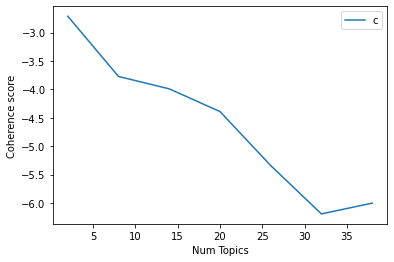

In [151]:
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [152]:
# Select the model and print the topics
optimal_model = model_list[3] # The 3rd index here gives us 19 topics 
model_topics = optimal_model.show_topics(formatted=False)
print(optimal_model.print_topics(num_words=10))

[(0, '0.053*"sale" + 0.048*"offer" + 0.030*"soon" + 0.026*"possible" + 0.024*"first" + 0.021*"mobile" + 0.020*"flipkart" + 0.018*"app" + 0.018*"want" + 0.017*"discount"'), (1, '0.047*"flipkart" + 0.043*"answer" + 0.039*"join" + 0.036*"brand" + 0.029*"gift" + 0.027*"great" + 0.027*"camera" + 0.022*"an" + 0.021*"contestalert" + 0.020*"launch"'), (2, '0.090*"product" + 0.076*"return" + 0.038*"flipkart" + 0.033*"order" + 0.029*"refund" + 0.028*"request" + 0.022*"replacement" + 0.020*"money" + 0.017*"send" + 0.017*"time"'), (3, '0.162*"order" + 0.074*"deliver" + 0.072*"delivery" + 0.043*"product" + 0.031*"day" + 0.030*"date" + 0.029*"cancel" + 0.028*"flipkart" + 0.021*"today" + 0.019*"place"'), (4, '0.090*"flipkart" + 0.036*"customer" + 0.035*"cheat" + 0.035*"fraud" + 0.035*"fake" + 0.028*"well" + 0.028*"company" + 0.024*"big" + 0.021*"online" + 0.019*"amazon"'), (5, '0.070*"card" + 0.055*"flipkart" + 0.055*"pay" + 0.042*"credit" + 0.038*"bank" + 0.032*"amount" + 0.030*"payment" + 0.022*"or

In [153]:
om_topics = optimal_model.print_topics(num_words=10)

In [154]:
with open(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-optimalmodel_topics.txt', "w") as output:
    output.write(str(om_topics))

In [155]:
def format_topics_sentences(ldamodel=optimal_model, corpus=corpus,lemma=data_lemmatized, texts=data_raw):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    lemm_content=pd.Series(lemma)
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, lemm_content,contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, lemma=data_lemmatized,texts=data_raw)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'lemm_text','Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,lemm_text,Text
0,0,18.0,0.5701,"account, flipkart, thank, block, share, check,...","[request, share, alternate, contact, number, l...",request share alternate contact number linked ...
1,1,1.0,0.2685,"flipkart, answer, join, brand, gift, great, ca...","[help, bot, outdated, say, thing, inspite, ask...",help bot outdated say thing inspite asking dif...
2,2,3.0,0.6581,"order, deliver, delivery, product, day, date, ...","[day, place, order, item, ship, day, extend, d...",day placing order item shipped yet day extendi...
3,3,6.0,0.3426,"phone, purchase, flipkart, order, mobile, repl...","[day, hear, help, size, issue, small, help, re...",day hearing please help od size issue small pl...
4,4,9.0,0.4113,"service, flipkart, bad, issue, customer, day, ...","[team, team, poor, also, good, buy, recently, ...",hitach team team poor also good bought recentl...
5,5,4.0,0.3837,"flipkart, customer, cheat, fraud, fake, well, ...","[purchase, new, last, month, work, customer, s...",purchased new last month working customer serv...
6,6,16.0,0.4860,"call, customer, care, issue, support, say, tim...","[need, help, get, issue, resolve, bring, thoms...",sir need help get issue resolved ...i brought ...
7,7,16.0,0.3176,"call, customer, care, issue, support, say, tim...","[flipkart, sell, fraud, policy, share, record,...",justice month clcm flipkart selling fraud poli...
8,8,9.0,0.4877,"service, flipkart, bad, issue, customer, day, ...","[flipkart, service, stop]",amazon flipkart service stopped
9,9,19.0,0.6833,"take, need, update, action, help, refund, get,...","[android, phone]",android one phone


In [156]:
df_dominant_topic.to_csv(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-HA_topics_text_final.csv')

In [157]:
Topic_1_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==1.0].Text
Topic_2_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==2.0].Text
Topic_3_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==3.0].Text
Topic_4_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==4.0].Text
Topic_5_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==5.0].Text
Topic_6_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==6.0].Text
Topic_7_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==7.0].Text
Topic_8_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==8.0].Text
Topic_9_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==9.0].Text
Topic_10_df = df_dominant_topic[df_dominant_topic['Dominant_Topic']==10.0].Text

In [158]:
def summarization(text):  #calculating score over here by statement by statement 
    #print(text, "------")
    number_tokens=len(word_tokenize(text))
    tagged=nltk.pos_tag(word_tokenize(text))
    number_nouns=len([word for word, pos in tagged if pos in ["NN","NNP","VBG"]])   # Trying to find number of nouns from the sentence via NN and NNP 
    #use NER to tag the named entities
    ners=nltk.ne_chunk(nltk.pos_tag(word_tokenize(text)),binary=False)
    number_ners=len([chunk for chunk in ners if hasattr(chunk,'label')]) # Through chunking we are able to find out NER -> NER helps to find out whether there are any people, location, organization mentioned in the sentence,  Then finding length of those chunks , so no of nouns and no no NERs we are finding. 
    score=(number_ners+number_nouns)/float(number_tokens) # Out of total tokens, how many no of nouns and no of ners are coming into picture. 
    return (score,text)

In [159]:
#Topic_1_df['text_weight']=Topic_1_df['Text'].apply(summarization)
df_sum_topic1 = df_dominant_topic[df_dominant_topic['Dominant_Topic']==1.0]

In [160]:
#df_sum_topic1[Text_weight] = df_sum_topic1['Text'].apply(summarization)
#df_sum_topic1 = df_sum_topic1[df_sum_topic1['Text'].notna()]
df_sum_topic1=df_sum_topic1[df_sum_topic1['Text'].str.strip().astype(bool)]
df_sum_topic1=df_sum_topic1.reset_index(drop=True)

In [161]:
df_sum_topic1['text_weight']=df_sum_topic1['Text'].apply(summarization)
#df_sum_topic1

In [162]:
#type(df_sum_topic1['text_weight'][1])
final_topic1_df = pd.DataFrame(df_sum_topic1['text_weight'].tolist(), index=df_sum_topic1.index)
final_topic1_df.columns = ['weights', 'Text']

In [163]:
final_topic1_df.head(10)

,weights,Text
0,0.571429,help bot outdated say thing inspite asking dif...
1,0.608696,sir flipkart pay limit increased deposit bill ...
2,0.375000,rating -) many startup better support option
3,0.200000,ans minute triviatime thebigbilliondays superc...
4,0.478261,softbank group corp talk flipkart invest $ mil...
5,0.750000,think techy gadget use home decoration fullonf...
6,0.666667,jai hind sir love guruji beautiful fantastic m...
7,0.750000,mah split battery crackthecode rogphone worshi...
8,0.375000,ans () micromax &amp; flipkart
9,0.000000,absolutely disappointing


In [164]:
final_topic1_df.head(10)
final_topic1_df[final_topic1_df.sort_values('weights', ascending=False)['weights']>0.5].sort_values('weights', ascending=False).reset_index(drop=True).to_csv(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-topic1_summary.csv')

C:\Users\Meteora\AppData\Local\Temp/ipykernel_3748/3834341429.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  final_topic1_df[final_topic1_df.sort_values('weights', ascending=False)['weights']>0.5].sort_values('weights', ascending=False).reset_index(drop=True).to_csv(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-topic1_summary.csv')


Printing the list of most common occuring words from Topic 1 with weight of Text greater than 0.5 

In [167]:
from collections import Counter
Counter(" ".join(final_topic1_df[final_topic1_df.sort_values('weights', ascending=False)['weights']>0.5].sort_values('weights', ascending=False).reset_index(drop=True)['Text']).split()).most_common(20)

C:\Users\Meteora\AppData\Local\Temp/ipykernel_3748/1212997729.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  Counter(" ".join(final_topic1_df[final_topic1_df.sort_values('weights', ascending=False)['weights']>0.5].sort_values('weights', ascending=False).reset_index(drop=True)['Text']).split()).most_common(20)


[('flipkart', 385),
 ('camera', 272),
 ('join', 269),
 ('fullonblockbusterchallenge', 259),
 ('mp', 199),
 ('quad', 169),
 ('answer', 161),
 ('true', 158),
 ('contestalert', 126),
 ('brand', 125),
 ('mah', 125),
 ('battery', 112),
 ('galaxyf', 108),
 ('fullonblockbuster', 94),
 ('fullonfab', 88),
 ('purchased', 78),
 ('received', 74),
 ('option', 73),
 ('company', 70),
 ('launch', 61)]

Representing the list of common words from Topic 1 with summarized weight more than 0.5 in the form of Word Cloud 

C:\Users\Meteora\AppData\Local\Temp/ipykernel_3748/3657750248.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  list1 = final_topic1_df[final_topic1_df.sort_values('weights', ascending=False)['weights']>0.5].sort_values('weights', ascending=False).reset_index(drop=True)['Text'].values


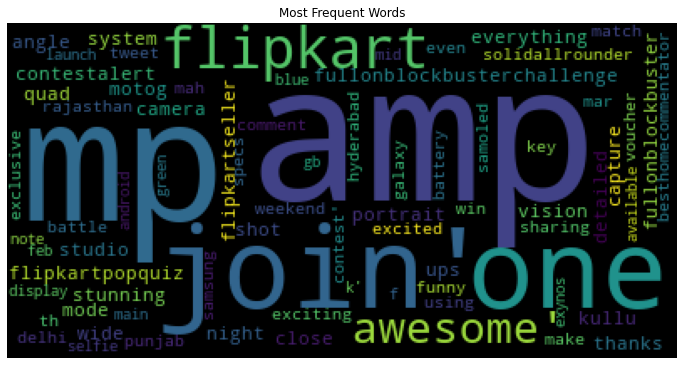

In [168]:
from wordcloud import WordCloud
list1 = final_topic1_df[final_topic1_df.sort_values('weights', ascending=False)['weights']>0.5].sort_values('weights', ascending=False).reset_index(drop=True)['Text'].values
wordcloud = WordCloud().generate(str(list1))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud.recolor(random_state=2017))
plt.title('Most Frequent Words')
plt.axis("off")
plt.show()

Fetching the dominant topic presence in each of the Tweets based on the number of topics obtained from the previous LDA model. 

In [169]:
train_vecs = []
for i in range(len(df)):
    top_topics = (
        optimal_model.get_document_topics(corpus[i], minimum_probability=0.0)
    )
    topic_vec = [top_topics[i][1] for i in range(10)]

    #topic_vec.extend([df.iloc[i].year])
    #topic_vec.extend([df.iloc[i].month])
    topic_vec.extend([df_dominant_topic.iloc[i].Dominant_Topic]	)
    topic_vec.extend([df_dominant_topic.iloc[i].Topic_Perc_Contrib]	)
    topic_vec.extend([df_dominant_topic.iloc[i].Keywords]	)
    topic_vec.extend([df_dominant_topic.iloc[i].lemm_text]	)
    topic_vec.extend([df.iloc[i].text])
    #print(topic_vec)
    train_vecs.append(topic_vec)

In [170]:
topic_vectors = pd.DataFrame(train_vecs, columns = ['Topic 0', 'Topic 1','Topic 2','Topic 3','Topic 4','Topic 5',
                                   'Topic 6','Topic 7','Topic 8','Topic 9','Dominant_topic','Contribution_prc','Keywords','lemm_text','Article'])
#print(topic_vectors)

Word Cloud Representation of the Generated topics via LDA  algorithm

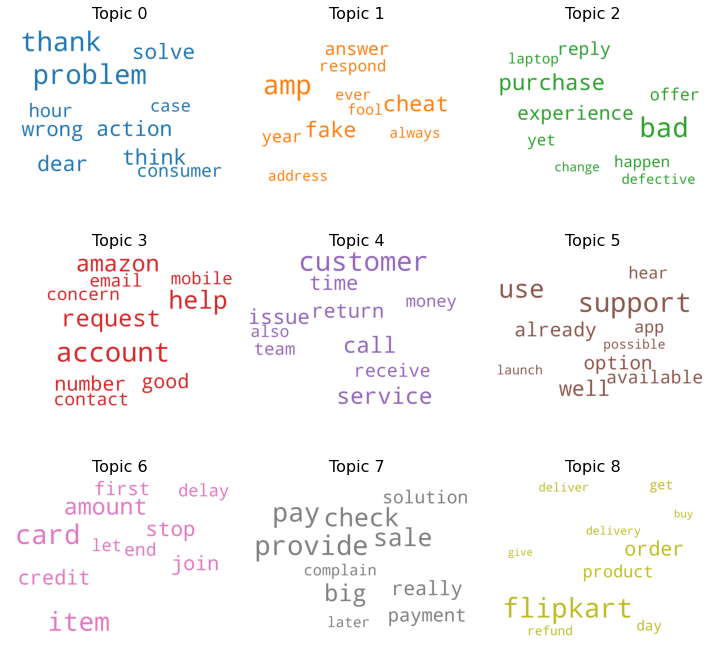

In [171]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stopwords,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Using PyLDA library to visualize the LDA generated topics

In [172]:
#import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word, mds='mmds')
vis

C:\Users\Meteora\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.402708  0.260408       1        1  34.473178
4      0.114932  0.447199       2        1  17.770070
3     -0.364852 -0.278551       3        1  11.816211
6     -0.262066  0.396587       4        1   6.347502
1      0.182978 -0.434092       5        1   5.796802
2     -0.146204  0.147489       6        1   5.637683
7     -0.096821 -0.374293       7        1   4.803854
0     -0.452555  0.026235       8        1   4.722417
9      0.178120 -0.063778       9        1   4.568923
5      0.443761 -0.127203      10        1   4.063359, topic_info=           Term          Freq         Total Category  logprob  loglift
7      flipkart  34341.000000  34341.000000  Default  30.0000  30.0000
12        order  16257.000000  16257.000000  Default  29.0000  29.0000
72     customer   9757.000000   9757.000000  Default  28.0000  28.0000
81      product  11055.000000  11055.000000  Default  27.0000  27.0000
27      service   6723.000000   6723.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
869       model    171.423483    172.347843  Topic10  -5.0668   3.1978
1003     highly    161.583375    162.507832  Topic10  -5.1259   3.1975
924   uninstall    157.315617    158.240026  Topic10  -5.1526   3.1973
2657      prize    154.045059    154.969473  Topic10  -5.1736   3.1972
966     awesome    150.903860    151.828226  Topic10  -5.1942   3.1971

[331 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
298       9  0.996896  accordingly
0         3  0.999863      account
269       8  0.998862       action
892       5  0.999258      address
744       4  0.998443          ago
...     ...       ...          ...
89        1  0.999555         work
1159      5  0.998214        write
280       8  0.999015        wrong
538       5  0.998711         year
68        6  0.999634          yet

[302 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 5, 4, 7, 2, 3, 8, 1, 10, 6])

In [173]:
pyLDAvis.save_html(vis, r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-lda-lmd.html')

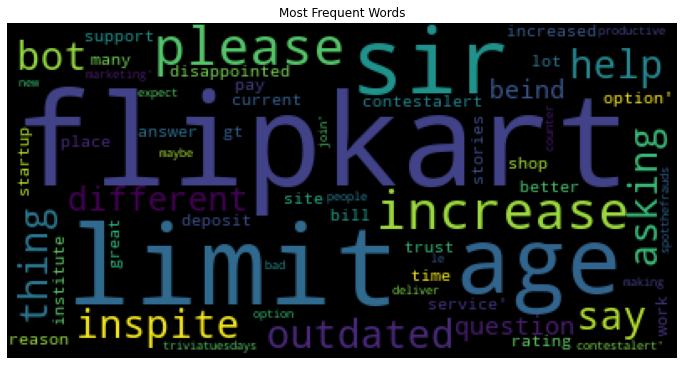

In [174]:
import matplotlib.pyplot as plt

text = Topic_1_df.values
wordcloud = WordCloud().generate(str(text))

plt.figure(figsize=(12,12))
plt.imshow(wordcloud.recolor(random_state=2017))
plt.title('Most Frequent Words')
plt.axis("off")
plt.show()

### Sentiment Analysis 

Using nltk package for perfomring Sentiment Analysis

In [175]:
from nltk.sentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [176]:
df_topic_1_weighted = pd.read_csv(r'C:\Users\Meteora\sandbox\Python_scripts\Text_Mining\Project\group_project\Twitter\github_p_subset\C1-topic1_summary.csv')

In [177]:
df_topic_1_weighted['polarity'] = df_topic_1_weighted['Text'].apply(lambda x: analyzer.polarity_scores(x))
df_topic_1_weighted.tail(3)

,Unnamed: 0,weights,Text,polarity
1137,1137,0.518519,"detailed close -ups, stunning portrait wide -a...","{'neg': 0.0, 'neu': 0.737, 'pos': 0.263, 'comp..."
1138,1138,0.516129,excited battle rajasthan &amp; hyderabad one p...,"{'neg': 0.071, 'neu': 0.518, 'pos': 0.411, 'co..."
1139,1139,0.512195,"[exclusive] samsung galaxy f key specs -, mah ...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [178]:
df_topic_1_weighted = pd.concat([df_topic_1_weighted,
     df_topic_1_weighted['polarity'].apply(pd.Series)], axis=1)

df_topic_1_weighted['sentiment'] = df_topic_1_weighted['compound'].apply(lambda x: 'positive' if x >0 else 'neutral' if x==0 else 'negative')

In [179]:
df_topic_1_weighted = df_topic_1_weighted.reset_index(drop=True)

Filtering out only positive reviwes from the Twitter data subset 

In [240]:
pos_df = df_topic_1_weighted[df_topic_1_weighted['sentiment']=='positive'].reset_index(drop=True)
#df_topic_1_weighted.loc[df_topic_1_weighted['compound'].idxmax()].values

Importing Word2Vec library from Gensim package 

In [241]:
from gensim.models import Word2Vec

from nltk.corpus import stopwords
my_stop_words = set(stopwords.words('english'))

In [242]:
from nltk.tokenize import sent_tokenize
good_reviews = ' '.join(pos_df.Text)

sentences_good = sent_tokenize(good_reviews)

good_token_clean = list()
import re
# get tokens for each sentence
for sentence in sentences_good:
    eng_word = re.findall(r'[A-Za-z\-]+', sentence)
    good_token_clean.append([i.lower() for i in eng_word if i.lower() not in my_stop_words])

In [243]:
sentences_good     #Contains the tokenized form of each of the sentences available in the good reviews 

['awesome fullonblockbusterchallenge fullonblockbuster join kullu flipkartpopquiz studio flipkartseller contestalert join join telegram kullu flipkartpopquiz flipkartseller studio join friend awesome answer .true mp quad camera fullonblockbusterchallenge join join answer contestalert triviacontest join spiderman homecoming biggesthomecoming thomson join flipkart perfume fullonfab join flipkart perfume fullonfab join awesome flipkart perfume brand fullonfab join awesome flipkart perfume fullonfab join kullu flipkartpopquiz flipkartseller studio join friend flipkart perfume fullonfab join gift love fullonblockbusterchallenge join answer contestalert powerofpartnership studio studipopquiz join friend spiderman homecoming contest thomson biggesthomecoming join flipkart perfume fullonfab join technology isobar techbar thoughtfullysimple join friend fullonblockbusterchallenge join send gift wow amazing camera feeling way gifting option place order gift awesome fullonblockbusterchallenge join

In [244]:
pos_df.shape

(680, 9)

Implementing Word2Vec CBOW model only for positive reviews 

In [249]:
model_ted = Word2Vec(sentences=good_token_clean, window=10, min_count=1, workers=4, sg=0)
model_ted.predict_output_word(['offer'], topn=10)

[('monitor', 0.00066167046),
 ('match', 0.0006616636),
 ('bang', 0.0006615752),
 ('told', 0.00066157436),
 ('youtube', 0.00066154456),
 ('someone', 0.00066145614),
 ('flipkartdailytrivia', 0.00066141214),
 ('cycle', 0.00066136895),
 ('optimization', 0.00066136144),
 ('wood', 0.0006613539)]

Implementing Word2Vec CBOW model only for negative reviews

In [232]:
neg_df = df_topic_1_weighted[df_topic_1_weighted['sentiment']=='negative'].reset_index(drop=True)

neg_reviews = ' '.join(neg_df.Text)
sentences_bad = sent_tokenize(neg_reviews)

good_token_clean = list()

# get tokens for each sentence
bad_token_clean = list()
for sentence in sentences_bad:
    eng_word = re.findall(r'[A-Za-z\-]+', sentence)
    bad_token_clean.append([i.lower() for i in eng_word if i.lower() not in my_stop_words])

model_ted = Word2Vec(sentences=bad_token_clean, window=10, min_count=1, workers=4, sg=0)
model_ted.predict_output_word(['deliver'], topn=10)   #Try putting sad here

[('consignment', 0.00224729),
 ('care', 0.0022472735),
 ('mistake', 0.0022472714),
 ('hai', 0.0022472625),
 ('crackthecode', 0.0022472613),
 ('seller', 0.0022472607),
 ('aggregation', 0.00224726),
 ('ppl', 0.0022472502),
 ('adress', 0.002247249),
 ('-the', 0.0022472488)]

In [238]:
neu_df = df_topic_1_weighted[df_topic_1_weighted['sentiment']=='neutral'].reset_index(drop=True)

neu_reviews = ' '.join(neu_df.Text)
sentences_neu = sent_tokenize(neu_reviews)

neu_token_clean = list()

# get tokens for each sentence
neu_token_clean = list()
for sentence in sentences_neu:
    eng_word = re.findall(r'[A-Za-z\-]+', sentence)
    neu_token_clean.append([i.lower() for i in eng_word if i.lower() not in my_stop_words])

model_ted = Word2Vec(sentences=neu_token_clean, window=10, min_count=1, workers=4, sg=0)
model_ted.predict_output_word(['customer'], topn=10)   #Try putting sad here

[('split', 0.0014144972),
 ('gb', 0.0014144747),
 ('advertisement', 0.0014144668),
 ('live', 0.001414466),
 ('studiopopquiz', 0.0014144656),
 ('hey', 0.0014144648),
 ('survive', 0.0014144646),
 ('service', 0.0014144637),
 ('snapdragon', 0.0014144633),
 ('refresh', 0.0014144622)]

Thus we see that from the sample dataset of the year 2020 & 2021 after performing Topic Modelling and obtaining Dominant topics and then perfomring Sentiment analysis on top of it -> we are trying to implement Word2Vec Model on it and are able to predict the words for each of the 3 different sentiments. 